# Tech Challenge 4 (Fase4)
# Desenvolvimento de Modelo LSTM para Previsão de Ativos (PETR4)

Este Projeto aborda a criação de uma Rede Neural Recorrente (LSTM) para prever o comportamento de preços da Petrobras. O foco não é apenas prever o preço exato, mas entender a tendência (se vai subir ou cair).

**O que será feito:**
1. Coletar dados históricos e macroeconômicos.
2. Criar indicadores técnicos (RSI, Médias Móveis, Volatilidade).
3. Preparar os dados para a rede neural (normalização e janelas de tempo).
4. Treinar o modelo usando uma validação que respeita a linha do tempo (Walk-Forward).
5. Simular uma estratégia de trading para ver se o modelo daria lucro.

Grupo da turma 6MELT (FIAP):
* Luca Poiti - RM365678
* Gabriel Jordan - RM365606
* Luciana Ferreira - RM366171
* Marcio Lima - RM365919



## Imports e Configurações
Fixando as "sementes" (seeds) para garantir que os resultados sejam reproduzíveis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
import math
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# !python --version
# !pip show pandas scikit-learn joblib numpy tensorflow

# Python 3.12.12
# Name: pandas Version: 2.2.2
# Name: scikit-learn Version: 1.6.1
# Name: joblib Version: 1.5.3
# Name: numpy Version: 2.0.2
# Name: tensorflow Version: 2.19.0

### Coleta dos dados principais

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Parâmetros Coleta de Dados ---
ticker = 'PETR4.SA'
today_date = datetime.now()
# 9 anos
previous_years = 9
start_date = (today_date - relativedelta(years=previous_years)).strftime('%Y-%m-%d')
end_date = today_date.strftime('%Y-%m-%d')
print(f"Ativo: {ticker} (de {start_date} até {end_date})")

Ativo: PETR4.SA (de 2017-01-02 até 2026-01-02)


In [4]:
# --- Coleta de Dados ---
print(f"Iniciando download do ativo principal: {ticker} (de {start_date} até {end_date})")
core = yf.download(ticker, start=start_date, end=end_date)

if isinstance(core.columns, pd.MultiIndex):
    core.columns = core.columns.droplevel(1)

core = core.dropna()

Iniciando download do ativo principal: PETR4.SA (de 2017-01-02 até 2026-01-02)


/tmp/ipython-input-371916692.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  core = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [5]:
# df.to_csv('PETR4_historico_2015_2025.csv')

### Funções utilitárias

In [6]:
def show_info(df):
  print(f"Qtde de Linhas e Colunas: {df.shape}")
  print(f"Colunas: {df.columns.tolist()}")
  print(f"Período: {df.index.min()} até {df.index.max()}")

def report_missing_stats(df, name="DataFrame"):
    print("=" * 60)
    print(f"Relatório de valores ausentes — {name}")
    print("=" * 60)

    total_rows = len(df)
    total_cols = len(df.columns)

    print(f"Linhas: {total_rows}")
    print(f"Colunas: {total_cols}\n")

    # Estatísticas gerais
    total_nan = df.isna().sum().sum()
    total_cells = total_rows * total_cols
    pct_nan = (total_nan / total_cells) * 100

    print(f"Total de células: {total_cells}")
    print(f"Total de NaNs: {total_nan}")
    print(f"% de NaNs no DF: {pct_nan:.2f}%\n")

    # Estatísticas por coluna
    nan_per_col = df.isna().sum()
    nan_pct_per_col = (nan_per_col / total_rows) * 100

    stats = pd.DataFrame({
        "NaNs": nan_per_col,
        "% NaNs": nan_pct_per_col
    }).sort_values("% NaNs", ascending=False)


In [7]:
show_info(core)

Qtde de Linhas e Colunas: (2242, 5)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume']
Período: 2017-01-02 00:00:00 até 2025-12-30 00:00:00


In [8]:
core.head(3)

Price,Close,High,Low,Open,Volume
Date,,,,,
2017-01-02,3.906968,3.917628,3.890978,3.901638,7525700
2017-01-03,4.130833,4.170808,3.984255,3.984255,39947800
2017-01-04,4.130833,4.178804,4.080197,4.117507,37071700


## Engenharia de Features (Criando Inteligência para o Modelo)

Uma rede neural não faz milagre apenas com o preço de fechamento. Precisamos dar contexto a ela. Aqui, vamos criar variáveis que ajudam a explicar o movimento do mercado:

1.  **Variáveis Macro:** Dólar, Petróleo (Brent), Ibovespa e Selic. Como o mercado só sabe desses dados *depois* que eles acontecem, aplicamos um atraso (Lag de t-1). Ou seja, usamos o Dólar de *ontem* para prever a Petrobras de *hoje*, evitando que o modelo "cole" do futuro.
2.  **Retornos:** Transformamos o preço em variação percentual (Log Return). Isso é crucial porque redes neurais trabalham melhor com variações pequenas e estacionárias do que com preços absolutos (como R$ 4,00 lá em 2000 e R$ 30,00 hoje).
3.  **Indicadores Técnicos:** RSI (força do movimento), Bandas de Bollinger (volatilidade) e Médias Móveis (tendência).
4.  **Dados Temporais:** Ensinamos ao modelo que meses e dias da semana são cíclicos (usando Seno e Cosseno), para ele capturar padrões sazonais.

### Features Macro e de Mercado (Contexto econômico)

As variáveis macroeconômicas fornecem contexto externo ao comportamento do preço
da PETR4. O câmbio USD/BRL e o preço do petróleo Brent representam fatores
estruturais diretamente relacionados ao modelo de negócios da empresa. O
Ibovespa captura o movimento geral do mercado acionário brasileiro, permitindo
diferenciar efeitos específicos do ativo de movimentos sistêmicos. A taxa Selic
representa o regime macroeconômico e o custo do capital ao longo do tempo.
Além dos níveis de preço, foram incluídos os retornos dessas variáveis para
capturar choques e variações de curto prazo relevantes ao mercado.

Para evitar vazamento de informação, as variáveis macroeconômicas foram defasadas em uma unidade temporal (t-1) (um dia de diferença), garantindo que apenas informações disponíveis até o momento da previsão fossem utilizadas pelo modelo.


In [9]:
macro = pd.DataFrame()
macro.index = core.index.tz_localize(None)

In [10]:
# DÓLAR (USDBRL)
print("Baixando USD/BRL...")
usdbrl = yf.download('BRL=X', start=start_date, end=end_date)['Close']
macro['USDBRL'] = usdbrl

/tmp/ipython-input-2196715783.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usdbrl = yf.download('BRL=X', start=start_date, end=end_date)['Close']


Baixando USD/BRL...


[*********************100%***********************]  1 of 1 completed


In [11]:
# PETRÓLEO BRENT
print("Baixando Petróleo Brent...")
brent_petroleum = yf.download('BZ=F', start=start_date, end=end_date)['Close']
macro['Brent'] = brent_petroleum

/tmp/ipython-input-4225789507.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  brent_petroleum = yf.download('BZ=F', start=start_date, end=end_date)['Close']


Baixando Petróleo Brent...


[*********************100%***********************]  1 of 1 completed


In [12]:
# IBOVESPA
print("Baixando Ibovespa...")
ibov = yf.download('^BVSP', start=start_date, end=end_date)['Close']
macro['Ibovespa'] = ibov

/tmp/ipython-input-3709237331.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start_date, end=end_date)['Close']


Baixando Ibovespa...


[*********************100%***********************]  1 of 1 completed


In [13]:
import requests

# SELIC - BCB API (Sistema Gerenciador de Séries Temporais)
def converter_formato_data(data_str):
  objeto_data = datetime.strptime(data_str, '%Y-%m-%d')
  data_formatada = objeto_data.strftime('%d/%m/%Y')
  return data_formatada

print("Baixando SELIC do BCB...")
try:
    url_selic = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={converter_formato_data(start_date)}&dataFinal={converter_formato_data(end_date)}'
    print(f'Link SELIC api:\n{url_selic}')
    response = requests.get(url_selic)
    selic_data = pd.DataFrame(response.json())

    # Conversão e Normalização (Removendo fuso horário para evitar KeyError)
    selic_data['data'] = pd.to_datetime(selic_data['data'], format='%d/%m/%Y').dt.tz_localize(None)
    selic_data['valor'] = pd.to_numeric(selic_data['valor'])
    selic_data.set_index('data', inplace=True)

    selic_series = selic_data['valor']
    macro['Selic'] = selic_series.reindex(macro.index, method='ffill')

except Exception as e:
    print(f"Erro ao baixar Selic: {e}")
    macro['Selic'] = float('nan')

# Forward fill para dados faltantes (finais de semana, feriados)
macro['USDBRL'].fillna(method='ffill', inplace=True)
macro['Brent'].fillna(method='ffill', inplace=True)
macro['Ibovespa'].fillna(method='ffill', inplace=True)

Baixando SELIC do BCB...
Link SELIC api:
https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=02/01/2017&dataFinal=02/01/2026


/tmp/ipython-input-1419568732.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  macro['USDBRL'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1419568732.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro['USDBRL'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1419568732.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The 

In [14]:
# Retornos do Ibovespa e correlações
macro['Ibov_Return'] = macro['Ibovespa'].pct_change()
macro['Brent_Return'] = macro['Brent'].pct_change()
macro['USD_Return'] = macro['USDBRL'].pct_change()

show_info(macro)

Qtde de Linhas e Colunas: (2242, 7)
Colunas: ['USDBRL', 'Brent', 'Ibovespa', 'Selic', 'Ibov_Return', 'Brent_Return', 'USD_Return']
Período: 2017-01-02 00:00:00 até 2025-12-30 00:00:00


In [50]:
macro.head()

,USDBRL,Brent,Ibovespa,Selic,Ibov_Return,Brent_Return,USD_Return
Date,,,,,,,
2017-01-02,3.2532,NaN,59589.0,0.050788,NaN,NaN,NaN
2017-01-03,3.2840,55.470001,61814.0,0.050788,0.037339,NaN,0.009468
2017-01-04,3.2635,56.459999,61589.0,0.050788,-0.003640,0.017847,-0.006242
2017-01-05,3.2141,56.889999,62071.0,0.050788,0.007826,0.007616,-0.015137
2017-01-06,3.1977,57.099998,61665.0,0.050788,-0.006541,0.003691,-0.005102


In [15]:
macro_lagged = macro.copy()

cols_to_lag = [
    'USDBRL',
    'Brent',
    'Ibovespa',
    'Selic',
    'Ibov_Return',
    'Brent_Return',
    'USD_Return'
]

for col in cols_to_lag:
    macro_lagged[f'{col}_t-1'] = macro_lagged[col].shift(1)

macro_lagged = macro_lagged.drop(columns=cols_to_lag)
macro_lagged = macro_lagged.dropna()

In [16]:
macro_lagged.head(5)

,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,Brent_Return_t-1,USD_Return_t-1
Date,,,,,,,
2017-01-05,3.2635,56.459999,61589.0,0.050788,-0.003640,0.017847,-0.006242
2017-01-06,3.2141,56.889999,62071.0,0.050788,0.007826,0.007616,-0.015137
2017-01-09,3.1977,57.099998,61665.0,0.050788,-0.006541,0.003691,-0.005102
2017-01-10,3.2222,54.939999,61700.0,0.050788,0.000568,-0.037828,0.007662
2017-01-11,3.1955,53.639999,62132.0,0.050788,0.007002,-0.023662,-0.008286


In [17]:
macro.tail(5)

,USDBRL,Brent,Ibovespa,Selic,Ibov_Return,Brent_Return,USD_Return
Date,,,,,,,
2025-12-22,5.5398,62.070000,158142.0,0.055131,-0.002089,0.026459,0.003351
2025-12-23,5.5900,62.380001,160456.0,0.055131,0.014632,0.004994,0.009062
2025-12-26,5.5195,60.639999,160897.0,0.055131,0.002748,-0.027894,-0.012612
2025-12-29,5.5425,61.939999,160490.0,0.055131,-0.002530,0.021438,0.004167
2025-12-30,5.5691,61.919998,161125.0,0.055131,0.003957,-0.000323,0.004799


### Retornos do Preço (Returns)

As features de retorno representam a variação percentual do preço de fechamento
ao longo do tempo, sendo fundamentais para normalizar a série temporal e
facilitar o aprendizado do modelo LSTM.

Diferentemente do preço absoluto, os retornos removem efeitos de escala,
tornando o modelo mais robusto a diferentes níveis de preço e períodos
históricos.

Além do retorno percentual tradicional, foi incluído o retorno logarítmico,
que apresenta melhores propriedades matemáticas, como simetria, aditividade no tempo e maior estabilidade estatística (bom para treinar LSTM).



In [18]:
df_returns = pd.DataFrame(index=core.index)

# Retorno Diário (Percentual) - Isso ajuda a normalizar os dados naturalmente
df_returns['return_1'] = core['Close'].pct_change() # retorno linear
df_returns['return_5'] = core['Close'].pct_change(periods=5)
df_returns['return_20'] = core['Close'].pct_change(periods=20)

df_returns['Log_Return'] = np.log(core['Close'] / core['Close'].shift(1))

df_returns.head(6)


,return_1,return_5,return_20,Log_Return
Date,,,,
2017-01-02,NaN,NaN,NaN,NaN
2017-01-03,0.057299,NaN,NaN,0.055717
2017-01-04,0.000000,NaN,NaN,0.000000
2017-01-05,0.016129,NaN,NaN,0.016000
2017-01-06,-0.005715,NaN,NaN,-0.005731
2017-01-09,-0.021072,0.045703,NaN,-0.021298


### Momentum e Tendência

As features de momentum e tendência têm como objetivo capturar a direção,
a força e a persistência dos movimentos de preço. A média móvel simples (SMA_20)
representa a tendência de curto/médio prazo, enquanto as features de momentum
medem a velocidade da variação do preço em diferentes horizontes temporais.
O RSI é utilizado para quantificar a força relativa do movimento, indicando
possíveis condições de sobrecompra ou sobrevenda. O MACD e sua linha de sinal
complementam essa análise ao identificar mudanças na tendência por meio da
diferença entre médias móveis exponenciais de curto e longo prazo.


In [19]:
momentum = pd.DataFrame(index=core.index)

# Média Móvel Simples (SMA) - Janela móvel
momentum['SMA_20'] = core['Close'].rolling(window=20).mean()
momentum['SMA_200'] = core['Close'].rolling(window=200).mean()
# Distância do preço para a média (Estacionário!)
momentum['Dist_SMA200'] = (core['Close'] / core['Close'].rolling(200).mean()) - 1

# Momentum
momentum['Momentum_5'] = core['Close'] - core['Close'].shift(5)
momentum['Momentum_10'] = core['Close'] - core['Close'].shift(10)
momentum['Momentum_20'] = core['Close'] - core['Close'].shift(20)

# RSI (Relative Strength Index)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

momentum['RSI_21'] = calculate_rsi(core['Close'], 21)

# MACD (Moving Average Convergence Divergence)
ema_12 = core['Close'].ewm(span=12, adjust=False).mean()
ema_26 = core['Close'].ewm(span=26, adjust=False).mean()
momentum['MACD'] = ema_12 - ema_26
momentum['MACD_Signal'] = momentum['MACD'].ewm(span=9, adjust=False).mean()

momentum = momentum.dropna()

momentum.head(5)

,SMA_20,SMA_200,Dist_SMA200,Momentum_5,Momentum_10,Momentum_20,RSI_21,MACD,MACD_Signal
Date,,,,,,,,,
2017-10-16,4.194660,3.791904,0.132958,0.061296,0.191885,0.287825,63.846192,0.103672,0.108274
2017-10-17,4.207852,3.793863,0.133075,-0.015990,0.039975,0.263840,63.938624,0.101100,0.106839
2017-10-18,4.211716,3.794742,0.134919,0.021320,0.133254,0.077287,63.281321,0.098571,0.105186
2017-10-19,4.218113,3.795608,0.133958,0.018656,0.066628,0.127923,54.487252,0.095254,0.103199
2017-10-20,4.225175,3.796235,0.138685,0.037310,0.141247,0.141247,59.197404,0.093057,0.101171


### Volatilidade

As features de volatilidade têm como objetivo capturar a intensidade e a
variação dos movimentos de preço ao longo do tempo. O ATR representa a
volatilidade intradiária real considerando gaps, o desvio padrão mede a
volatilidade estatística em uma janela fixa, a largura das Bandas de Bollinger
indica períodos de expansão e contração da volatilidade, e a volatilidade de
Parkinson utiliza os extremos diário de preço (máxima e mínima) para uma
estimativa mais eficiente.

In [20]:
volatility = pd.DataFrame(index=core.index)

# ATR (Average True Range)
high_low = core['High'] - core['Low']
high_close = np.abs(core['High'] - core['Close'].shift())
low_close = np.abs(core['Low'] - core['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
volatility['ATR_14'] = true_range.rolling(14).mean()


# Bandas de Bollinger
volatility['BB_Middle'] = core['Close'].rolling(window=20).mean()
volatility['BB_Std'] = core['Close'].rolling(window=20).std()
volatility['BB_Upper'] = volatility['BB_Middle'] + (volatility['BB_Std'] * 2)
volatility['BB_Lower'] = volatility['BB_Middle'] - (volatility['BB_Std'] * 2)
volatility['BB_Width'] = (volatility['BB_Upper'] - volatility['BB_Lower']) / volatility['BB_Middle']
volatility['BB_Position'] = (core['Close'] - volatility['BB_Lower']) / (volatility['BB_Upper'] - volatility['BB_Lower'])

# Volatilidade (Desvio Padrão) - Janela móvel
volatility['STD_20'] = core['Close'].rolling(window=20).std()

# Volatilidade de Parkinson (usando High e Low)
volatility['Parkinson_Vol'] = np.sqrt(1/(4*np.log(2)) * (np.log(core['High']/core['Low'])**2))

# Em vez de High/Low, usamos volatilidade ou range percentual
volatility['Range_High_Low'] = (core['High'] - core['Low']) / core['Close']

volatility = volatility.dropna()

volatility.head()

,ATR_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,BB_Width,BB_Position,STD_20,Parkinson_Vol,Range_High_Low
Date,,,,,,,,,,
2017-01-30,0.101843,4.164678,0.093966,4.352609,3.976747,0.090250,-0.058017,0.093966,0.027294,0.046496
2017-01-31,0.105269,4.169475,0.081775,4.333025,4.005926,0.078451,-0.009218,0.081775,0.018651,0.031292
2017-02-01,0.106983,4.163079,0.089586,4.342251,3.983907,0.086077,0.053031,0.089586,0.019809,0.033289
2017-02-02,0.103746,4.154951,0.099493,4.353937,3.955965,0.095783,0.030907,0.099493,0.016739,0.028207
2017-02-03,0.107363,4.149488,0.100035,4.349557,3.949418,0.096431,0.346812,0.100035,0.022741,0.037158


### Volume

As features de volume têm como objetivo capturar a intensidade da participação
do mercado nos movimentos de preço. O On-Balance Volume (OBV) acumula o volume
negociado de acordo com a direção do preço, auxiliando na identificação de
pressão compradora ou vendedora. O Volume Ratio normaliza o volume diário em
relação à média recente, permitindo detectar períodos de atividade atípica.
O VWAP representa o preço médio ponderado pelo volume ao longo do tempo,
servindo como referência de equilíbrio entre preço e liquidez.


In [21]:
volume = pd.DataFrame(index=core.index)

# OBV (On-Balance Volume)
volume['OBV'] = (np.sign(core['Close'].diff()) * core['Volume']).fillna(0).cumsum()

volume_SMA_20 = core['Volume'].rolling(20).mean()
volume['Volume_Ratio'] = core['Volume'] / volume_SMA_20

# VWAP (Volume Weighted Average Price)
volume['VWAP'] = (core['Volume'] * (core['High'] + core['Low'] + core['Close']) / 3).cumsum() / core['Volume'].cumsum()

volume = volume.dropna()

volume.head()

,OBV,Volume_Ratio,VWAP
Date,,,
2017-01-30,86741000.0,0.863023,4.188877
2017-01-31,117548200.0,0.956925,4.181049
2017-02-01,117548200.0,1.124442,4.173027
2017-02-02,78241500.0,1.224235,4.163681
2017-02-03,118454900.0,1.267022,4.157068


### Features Temporais (Encoding Temporal Cíclico)

Variáveis temporais como dia da semana e mês do ano possuem natureza cíclica,
onde o final de um ciclo é conceitualmente próximo do início do próximo.
Para preservar essa característica, foi aplicado o encoding senoidal, utilizando
funções seno e cosseno. Essa representação evita relações ordinais artificiais
e permite que o modelo LSTM capture padrões sazonais de forma mais consistente.


In [22]:
temporal = pd.DataFrame(index=core.index)

# Dia da semana (0–4) Day Of the Week
dow = core.index.dayofweek
temporal['DoW_sin'] = np.sin(2 * np.pi * dow / 5)
temporal['DoW_cos'] = np.cos(2 * np.pi * dow / 5)

# Mês do ano (1–12)
month = core.index.month
temporal['Month_sin'] = np.sin(2 * np.pi * month / 12)
temporal['Month_cos'] = np.cos(2 * np.pi * month / 12)


temporal.tail(10)

,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,
2025-12-15,0.000000,1.000000,-2.449294e-16,1.0
2025-12-16,0.951057,0.309017,-2.449294e-16,1.0
2025-12-17,0.587785,-0.809017,-2.449294e-16,1.0
2025-12-18,-0.587785,-0.809017,-2.449294e-16,1.0
2025-12-19,-0.951057,0.309017,-2.449294e-16,1.0
2025-12-22,0.000000,1.000000,-2.449294e-16,1.0
2025-12-23,0.951057,0.309017,-2.449294e-16,1.0
2025-12-26,-0.951057,0.309017,-2.449294e-16,1.0
2025-12-29,0.000000,1.000000,-2.449294e-16,1.0


### Consolidação das Features

In [23]:
# df Principal
df = pd.DataFrame()
df = pd.concat(
    [core, macro_lagged, df_returns, momentum, volatility, volume, temporal]
    , axis=1
).reindex(core.index)
df.index = df.index.tz_localize(None)

# Remove períodos iniciais incompletos
df.dropna(thresh=len(df.columns)*0.7, inplace=True)

# Preenchimento temporal
df.fillna(method='ffill', inplace=True)

# Segurança final
df.dropna(inplace=True)

show_info(df)

report_missing_stats(df, name="df Principal")

df.head()

Qtde de Linhas e Colunas: (2043, 42)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume', 'USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Log_Return', 'SMA_20', 'SMA_200', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-16 00:00:00 até 2025-12-30 00:00:00
Relatório de valores ausentes — df Principal
Linhas: 2043
Colunas: 42

Total de células: 85806
Total de NaNs: 0
% de NaNs no DF: 0.00%



/tmp/ipython-input-2690883577.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,Close,High,Low,Open,Volume,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,...,STD_20,Parkinson_Vol,Range_High_Low,OBV,Volume_Ratio,VWAP,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,4.296066,4.333377,4.264085,4.306726,44699700,3.1690,57.169998,76990.0,0.031096,0.004305,...,0.084034,0.009681,0.016129,407387800.0,1.129012,3.784882,0.000000,1.000000,-0.866025,0.5
2017-10-17,4.298730,4.322716,4.282740,4.301395,25524800,3.1462,57.820000,76892.0,0.031096,-0.001273,...,0.078135,0.005580,0.009299,432912600.0,0.653192,3.786585,0.951057,0.309017,-0.866025,0.5
2017-10-18,4.306726,4.338706,4.298730,4.322716,25706200,3.1703,57.880001,76201.0,0.031096,-0.008987,...,0.081113,0.005559,0.009282,458618800.0,0.707206,3.788332,0.587785,-0.809017,-0.866025,0.5
2017-10-19,4.304061,4.306726,4.237435,4.264085,24672800,3.1561,58.150002,76591.0,0.031096,0.005118,...,0.083177,0.009741,0.016099,433946000.0,0.699547,3.789897,-0.587785,-0.809017,-0.866025,0.5
2017-10-20,4.322715,4.368021,4.309390,4.314720,32417500,3.1701,57.230000,76283.0,0.031096,-0.004021,...,0.085856,0.008116,0.013563,466363500.0,0.930358,3.792148,-0.951057,0.309017,-0.866025,0.5


### Gráficos Históricos das PETR4.SA

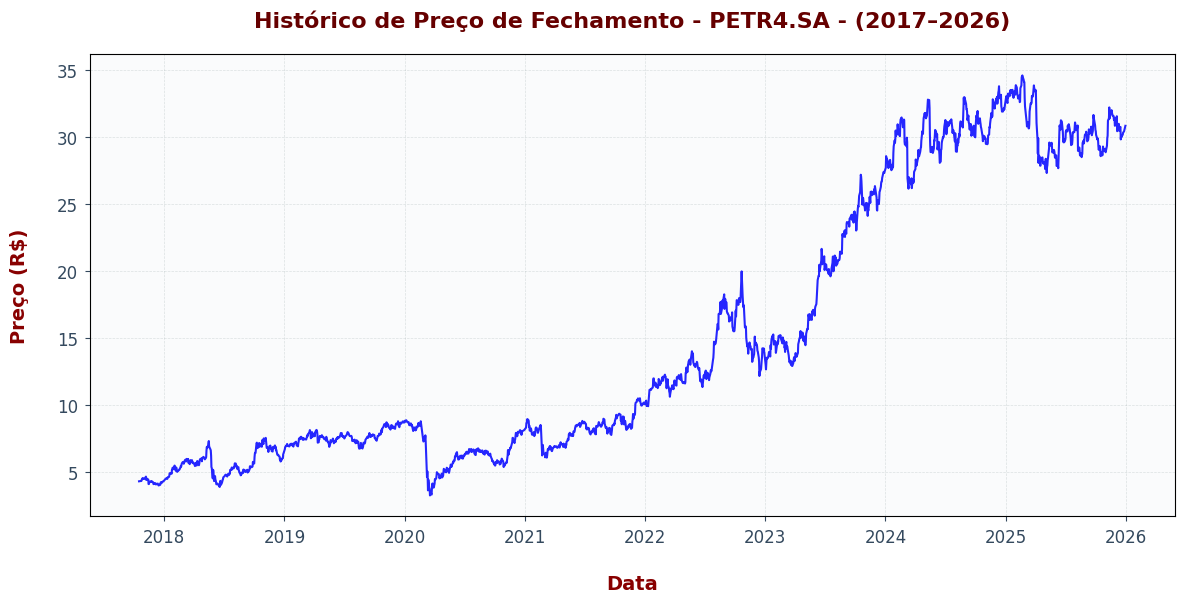

In [24]:
data = df.loc[start_date:end_date]

format_string = '%Y-%m-%d'
start_date_object = datetime.strptime(start_date, format_string)
end_date_object = datetime.strptime(end_date, format_string)
min_year = (start_date_object).year
max_year = (end_date_object).year

# Configurar o estilo do gráfico
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')
ax.tick_params(colors='#34495e', labelsize=12, pad=5)

# plotar dados
plt.plot(data.filter(['Close']), linewidth=1.5, color='blue', alpha=0.85 )

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')
plt.title(f'Histórico de Preço de Fechamento - {ticker} - ({min_year}–{max_year})', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço (R$)', fontsize=14, color='#880000', fontweight='bold', labelpad=20)

plt.show()

### Visualização Trimestral (Gráfico Candlestick)

Para visualizar a tendência de longo prazo de forma mais limpa, criamos um gráfico de Candlestick agrupado por trimestres. Em vez de plotar cada dia individualmente, utilizamos a técnica de **Resampling** para resumir cada 3 meses em uma única "vela" que contém quatro informações vitais: preços de abertura, fechamento, máxima e mínima. As velas verdes indicam trimestres de alta (fechamento maior que a abertura) e as vermelhas, de baixa. Essa abordagem ajuda a identificar os grandes ciclos e movimentos estruturais do ativo, filtrando o "ruído" da volatilidade diária.

In [25]:
# Mês:
# 'ME' (Month End - fim do mês)
# 'MS' (Month Start - início do mês)
# Trimestre:
# 'QE' (Quarter End - fim do trimestre)
# 'QS' (Quarter Start - início do trimestre)
# Quadrimestre:
# '4ME' (a cada 4 meses, fim do mês)
# '4MS' (a cada 4 meses, início do mês)

df_periodo = df.resample('3ME').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})

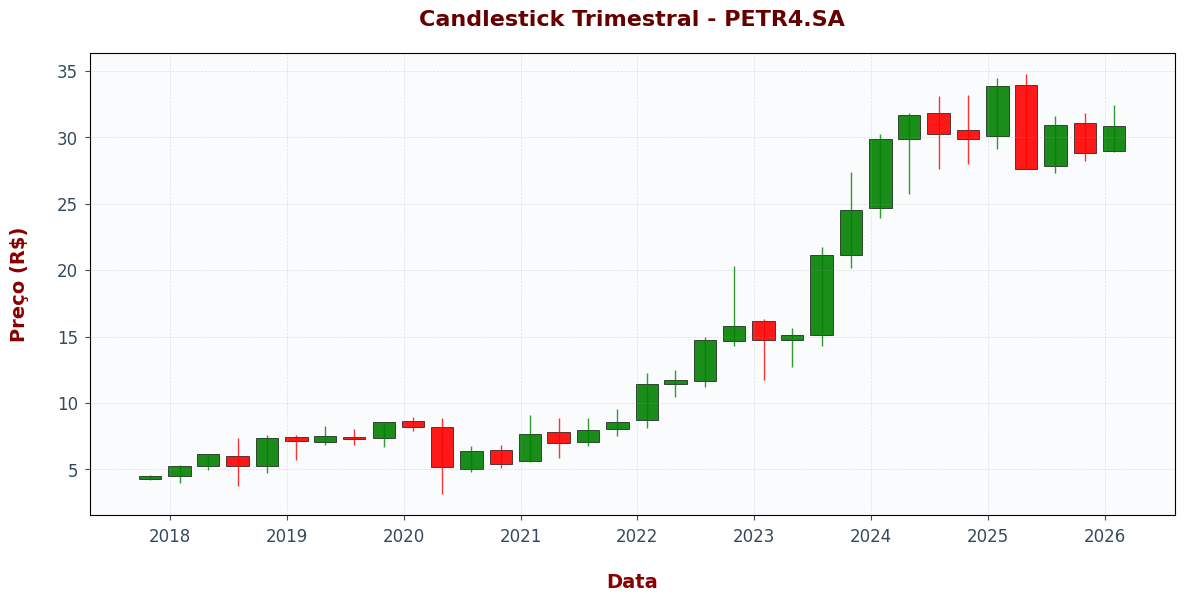

In [26]:
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')
ax.tick_params(colors='#34495e', labelsize=12, pad=5)

# Ajuste da largura do candle (em dias)
candle_width = 70  # bom para trimestral/semestral

for date, row in df_periodo.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'

    # Pavio (mínima até máxima)
    plt.vlines(
        x=date,
        ymin=row['Low'],
        ymax=row['High'],
        color=color,
        linewidth=1,
        alpha=0.8
    )

    # Corpo do candle
    plt.bar(
        x=date,
        height=row['Close'] - row['Open'],
        bottom=row['Open'],
        width=candle_width,
        color=color,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.9
    )

plt.title(f'Candlestick Trimestral - {ticker}', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço (R$)', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')

plt.show()


### Tendência e Volatilidade (Janela Móvel)

Este gráfico combina a direção do preço com a sua intensidade. A linha azul representa a **Média Móvel Simples (SMA) de 20 dias**, que funciona como um filtro de ruído, mostrando a tendência de curto prazo do ativo. A área sombreada ao redor da média representa a **volatilidade** (desvio padrão): quanto mais larga a banda, mais agitado e incerto está o mercado; quanto mais estreita, mais estável. Visualizar essa "faixa" ajuda a entender o comportamento estatístico que a rede LSTM tentará aprender: movimentos dentro da faixa são normais, enquanto rompimentos indicam eventos de mercado significativos.

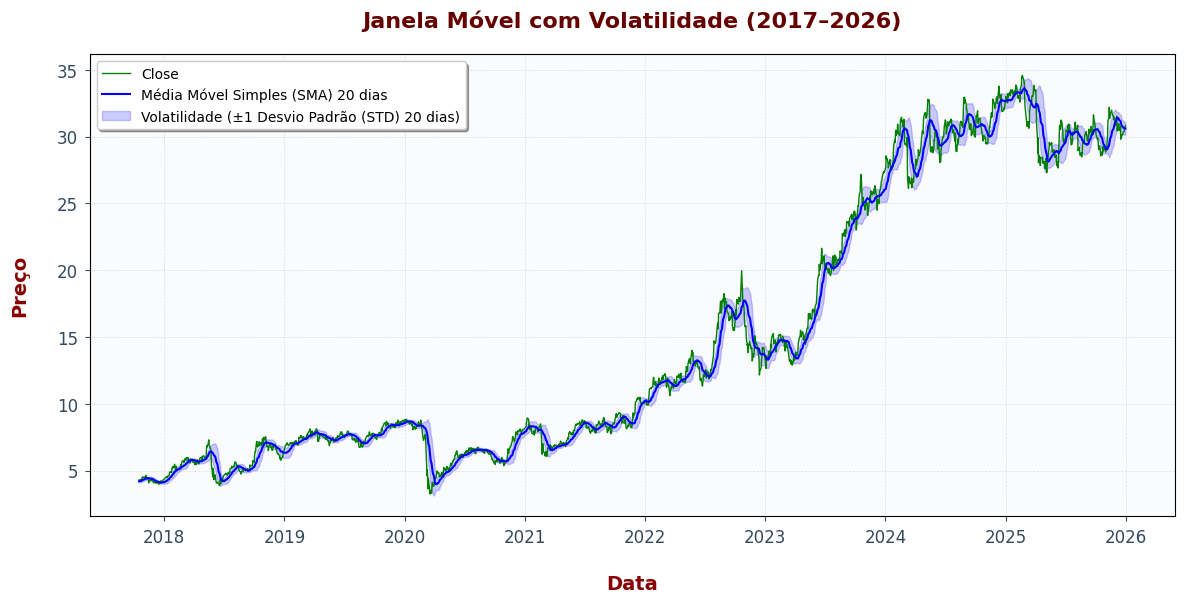

In [27]:
data = df.loc[start_date:end_date]

# Configurar o estilo do gráfico
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')

plt.plot(data.index, data['Close'], label='Close', linewidth=1, color='green')
plt.plot(data.index, data['SMA_20'], label='Média Móvel Simples (SMA) 20 dias', linewidth=1.5, color='blue')

# Banda superior é: SMA_200 + (1 × STD_200)
upper_band = df['SMA_20'] + df['STD_20']
# Banda inferior é: SMA_200 - (1 × STD_200)
lower_band = df['SMA_20'] - df['STD_20']
plt.fill_between(
    df.index,
    upper_band,
    lower_band,
    alpha=0.2,
    color='blue',
    label='Volatilidade (±1 Desvio Padrão (STD) 20 dias)'
)

plt.title(f'Janela Móvel com Volatilidade ({min_year}–{max_year})', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')

ax.tick_params(colors='#34495e', labelsize=12, pad=5)

plt.show()


In [28]:
df.head()

,Close,High,Low,Open,Volume,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,...,STD_20,Parkinson_Vol,Range_High_Low,OBV,Volume_Ratio,VWAP,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,4.296066,4.333377,4.264085,4.306726,44699700,3.1690,57.169998,76990.0,0.031096,0.004305,...,0.084034,0.009681,0.016129,407387800.0,1.129012,3.784882,0.000000,1.000000,-0.866025,0.5
2017-10-17,4.298730,4.322716,4.282740,4.301395,25524800,3.1462,57.820000,76892.0,0.031096,-0.001273,...,0.078135,0.005580,0.009299,432912600.0,0.653192,3.786585,0.951057,0.309017,-0.866025,0.5
2017-10-18,4.306726,4.338706,4.298730,4.322716,25706200,3.1703,57.880001,76201.0,0.031096,-0.008987,...,0.081113,0.005559,0.009282,458618800.0,0.707206,3.788332,0.587785,-0.809017,-0.866025,0.5
2017-10-19,4.304061,4.306726,4.237435,4.264085,24672800,3.1561,58.150002,76591.0,0.031096,0.005118,...,0.083177,0.009741,0.016099,433946000.0,0.699547,3.789897,-0.587785,-0.809017,-0.866025,0.5
2017-10-20,4.322715,4.368021,4.309390,4.314720,32417500,3.1701,57.230000,76283.0,0.031096,-0.004021,...,0.085856,0.008116,0.013563,466363500.0,0.930358,3.792148,-0.951057,0.309017,-0.866025,0.5


In [29]:
show_info(df)

Qtde de Linhas e Colunas: (2043, 42)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume', 'USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Log_Return', 'SMA_20', 'SMA_200', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-16 00:00:00 até 2025-12-30 00:00:00


In [30]:
# df.to_csv('PETR4_historico.csv')

## Pré-processamento: Preparando o para o treinamento da rede neural (LSTM)

Agora vamos formatar os dados para a "visão" da Inteligência Artificial.

**1. Definição do Alvo (Target):**
Vamos prever o `Log_Return`. Se previmos o retorno corretamente, conseguimos calcular o preço final. Tentar prever o preço direto (ex: R$ 35,50) costuma gerar resultados piores porque a rede fica "viciada" nos valores mais recentes.

**2. Validação Temporal (Walk-Forward):**
Não podemos simplesmente embaralhar os dados (como num sorteio). O mercado segue uma ordem cronológica. Usaremos o `TimeSeriesSplit`. Imagine uma janela deslizante: a gente treina num pedaço do passado e testa no pedaço seguinte do futuro, depois avança a janela e repete. Isso simula a vida real.

**3. Normalização (Escalonamento):**
Redes neurais são sensíveis à matemática. Se entrarmos com "Volume" na casa dos milhões e "Retorno" na casa de 0.01, ela vai ignorar o retorno. O `MinMaxScaler` coloca tudo na mesma régua (entre 0 e 1).

Separando target (y) e features (X)

In [31]:
#target_col = 'Close'
target_col = 'Log_Return'
# Lista do que NÃO queremos que o modelo veja (Preços Absolutos)
colunas_proibidas = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_200', target_col]

# Criamos o X removendo essas colunas
X = df.drop(columns=colunas_proibidas, errors='ignore')

y = df[target_col]


In [32]:
show_info(X)

Qtde de Linhas e Colunas: (2043, 34)
Colunas: ['USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-16 00:00:00 até 2025-12-30 00:00:00


Escalonamento das features, separação em dados de treino e teste e Avaliação

Walk-Forward foi a técnica usada para separar treino e teste das séries temporais que respeita a ordem do tempo. Em vez de fazer um único corte 80/20, você faz múltiplos cortes sequenciais, sempre treinando no passado e testando no futuro.

In [33]:
# +- 2500 registros no tempo
# Split 1: [====treino====][-gap-][teste]
# Split 2: [========treino========][-gap-][teste]
# Split 3: [============treino============][-gap-][teste]
# Split 4: [================treino================][-gap-][teste]
# Split 5: [====================treino====================][-gap-][teste]

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Configuração da validação temporal
n_samples = df.shape[0]
if n_samples == 0:
    raise ValueError("Seu DataFrame (X) está vazio! Verifique o carregamento dos dados.")

n_splits = 4
gap = 20
espaco_util = n_samples - (n_splits * gap)
max_safe_test_size = math.floor(espaco_util / (n_splits + 1))
test_size_desejado = int(n_samples * 0.10) # 15%
test_size = min(test_size_desejado, max_safe_test_size)
if test_size < 1:
    raise ValueError("Não há dados suficientes para realizar o split com este Gap.")

print(f"Configuração definida: n_splits={n_splits}, gap={gap}, test_size={test_size}")
print(f"(Test size original era {test_size_desejado}, ajustado para caber nos splits)")

tscv = TimeSeriesSplit(
    n_splits=n_splits,    # 5 folds de validação
    test_size=test_size,  # ~15% para teste
    gap=gap               # Gap de 20 dias para evitar leakage das features com lag
)

# Colunas cíclicas (NÃO devem ser escaladas)
cyclical_cols = ['DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']


Configuração definida: n_splits=4, gap=20, test_size=204
(Test size original era 204, ajustado para caber nos splits)


### Janelas de Tempo (Sequências)

A LSTM precisa de memória. Não adianta mostrar só o dado de hoje para prever amanhã. Precisamos mostrar uma "filme".
A função `create_sequences` pega o dataset e fatia em janelas de 20 dias (Lookback).
*   **Entrada (X):** Dias 1 ao 20.
*   **Saída Esperada (y):** Dia 21.

In [35]:
def create_sequences(X, y, lookback=20):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X.iloc[i-lookback:i].values)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


## Arquitetura da Rede Neural (Stacked LSTM)

*   **LSTM Layers:** Camadas que têm memória. Usamos duas empilhadas para que a rede aprenda padrões simples na primeira e complexos na segunda.
*   **Dropout (0.2):** O "esquecimento proposital". Durante o treino, desligamos 20% dos neurônios aleatoriamente. Isso força a rede a não decorar os dados (evita Overfitting) e a aprender caminhos alternativos.
*   **Loss (Huber):** Nossa função de erro. Ela é menos sensível a movimentos muito bruscos (outliers) do que a média quadrática comum, o que é ótimo para ações voláteis.

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape), # Camada de Entrada
        LSTM(64, return_sequences=True), # 1ª Camada LSTM: Retorna sequências para permitir o empilhamento
        LSTM(32), # 2ª Camada LSTM: Condensa o aprendizado temporal
        Dropout(0.2), # Regularização para evitar Overfitting
        Dense(1) # Saída: 1 neurônio (Previsão do Log Return)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='huber' # 'mse' antes era
    )

    return model


In [37]:
# X_train_scaled.to_csv('PETR4_historico_scalled.csv')
# X_train_scaled

## Treinamento e Validação

Agora o código vai rodar os "Folds" (as divisões de tempo). Para cada período:
1.  Separa treino e teste sem misturar futuro com passado.
2.  Normaliza os dados (aprende a escala só no treino e aplica no teste).
3.  Treina a LSTM.
4.  Faz a previsão e "desnormaliza" para voltarmos ao valor em Reais.
5.  Mede o erro (RMSE/MAE) e verifica se acertou a direção do mercado (Subiu/Caiu).


📦 Fold 1
Seq treino: (1187, 20, 34)
Seq teste : (184, 20, 34)


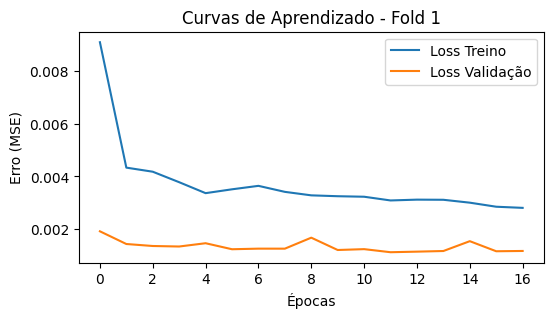

RMSE: 0.4079
MAE : 0.3037
Acurácia Direcional: 49.46%
Desvio Padrão das Previsões: 0.00362


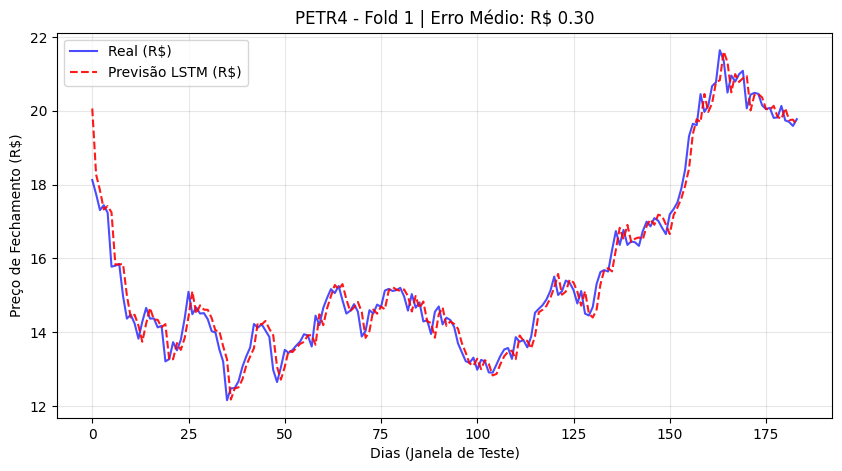


📦 Fold 2
Seq treino: (1391, 20, 34)
Seq teste : (184, 20, 34)


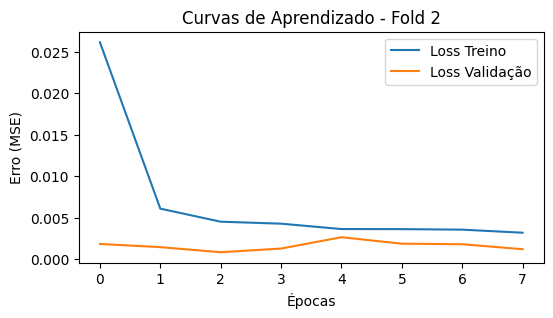

RMSE: 0.6139
MAE : 0.4797
Acurácia Direcional: 46.20%
Desvio Padrão das Previsões: 0.01161


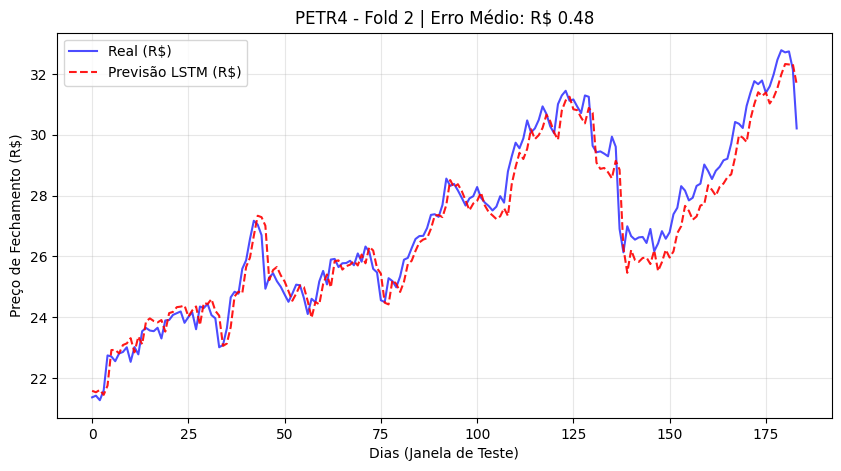


📦 Fold 3
Seq treino: (1595, 20, 34)
Seq teste : (184, 20, 34)


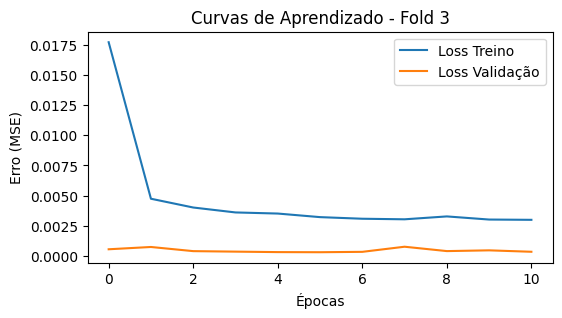

RMSE: 0.4242
MAE : 0.3186
Acurácia Direcional: 48.91%
Desvio Padrão das Previsões: 0.00364


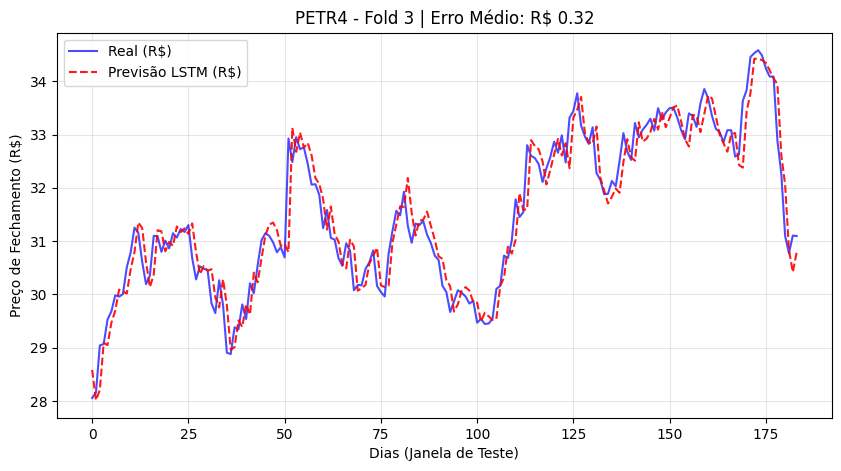


📦 Fold 4
Seq treino: (1799, 20, 34)
Seq teste : (184, 20, 34)


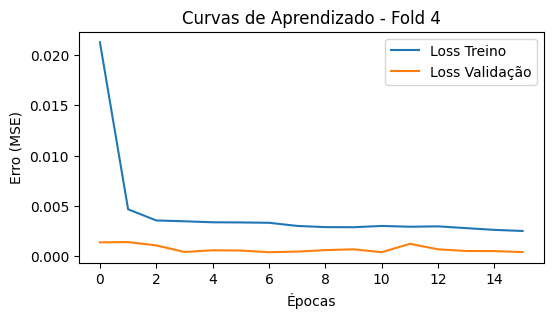

RMSE: 0.4620
MAE : 0.3534
Acurácia Direcional: 44.57%
Desvio Padrão das Previsões: 0.00665


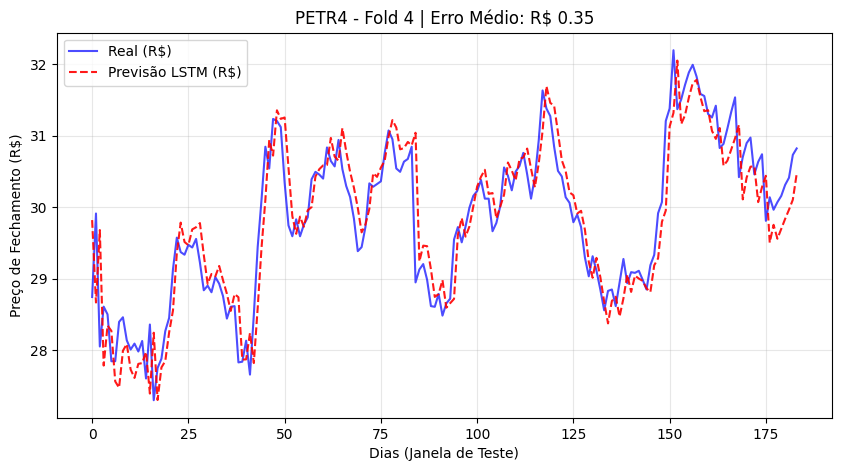

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# HIPERPARÂMETROS
LOOKBACK = 20 # memória urta
EPOCHS = 50
BATCH_SIZE = 32


metrics = []

# Lista para guardar todas as previsões de todos os folds
all_backtest_data = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):

    print(f'\n📦 Fold {fold}')

    # =======================
    # Split temporal
    # =======================
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # =======================
    # Escalonamento
    # =======================
    scale_cols = [c for c in X_train.columns if c not in cyclical_cols]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled  = X_test.copy()

    X_train_scaled[scale_cols] = scaler_X.fit_transform(X_train[scale_cols])
    X_test_scaled[scale_cols]  = scaler_X.transform(X_test[scale_cols])

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

    # =======================
    # Criação das sequências
    # =======================
    X_train_seq, y_train_seq = create_sequences(
        X_train_scaled, y_train_scaled, LOOKBACK
    )
    X_test_seq, y_test_seq = create_sequences(
        X_test_scaled, y_test_scaled, LOOKBACK
    )

    print(f'Seq treino: {X_train_seq.shape}')
    print(f'Seq teste : {X_test_seq.shape}')

    # Verificação de segurança para folds muito pequenos
    if len(X_test_seq) == 0:
        print("Fold pulado: dados insuficientes após Lookback.")
        continue

    # =======================
    # Modelo
    # =======================
    model = build_lstm(
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    # =======================
    # Diagnóstico de Aprendizado (Tira-Teima Overfitting)
    # =======================
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.title(f'Curvas de Aprendizado - Fold {fold}')
    plt.xlabel('Épocas')
    plt.ylabel('Erro (MSE)')
    plt.legend()
    plt.show()

    # =======================
    # Previsão
    # =======================
    y_pred_scaled = model.predict(X_test_seq, verbose=0)

    # Desescalar
    y_test_log = scaler_y.inverse_transform(y_test_seq)
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

    # =======================
    # RECONSTRUÇÃO DE PREÇOS
    # =======================

    # 1. Identificar quais índices do DF original correspondem às previsões
    # O create_sequences "come" as primeiras 'LOOKBACK' linhas do teste
    valid_test_idx = test_idx[LOOKBACK:]

    # 2. Pegar o preço de fechamento do DIA ANTERIOR (t-1) para cada previsão
    # Usamos o shift(1) no df original e selecionamos os índices
    base_prices = df['Close'].shift(1).iloc[valid_test_idx].values

    # 3. Aplicar a fórmula: Preco = Base * exp(Log_Return)
    # .flatten() garante que os arrays tenham dimensão (N,) para multiplicar correto
    price_real = base_prices * np.exp(y_test_log.flatten())
    price_pred = base_prices * np.exp(y_pred_log.flatten())

    # =======================
    # Métricas
    # =======================
    rmse_price = np.sqrt(mean_squared_error(price_real, price_pred))
    mae_price  = mean_absolute_error(price_real, price_pred)

    print(f'RMSE: {rmse_price:.4f}')
    print(f'MAE : {mae_price:.4f}')

    # Como o target é Log Return, basta ver se é maior que zero
    # .flatten() garante que o array seja 1D (lista simples)
    real_direction = (y_test_log.flatten() > 0).astype(int)
    pred_direction = (y_pred_log.flatten() > 0).astype(int)

    acc = accuracy_score(real_direction, pred_direction)
    print(f'Acurácia Direcional: {acc:.2%}') # Esperamos algo > 50%

    # Diagnóstico do "Random Walk" (Se o modelo está chutando sempre a média)
    print(f"Desvio Padrão das Previsões: {np.std(y_pred_log):.5f}")
    # Se o desvio for muito perto de 0 (ex: 0.00001), o modelo "morreu" e está chutando uma linha reta

    # =======================
    # Gráfico
    # =======================
    plt.figure(figsize=(10, 5))
    plt.plot(price_real, label='Real (R$)', color='blue', alpha=0.7)
    plt.plot(price_pred, label='Previsão LSTM (R$)', color='red', linestyle='--', alpha=0.9)

    plt.title(f'PETR4 - Fold {fold} | Erro Médio: R$ {mae_price:.2f}')
    plt.xlabel('Dias (Janela de Teste)')
    plt.ylabel('Preço de Fechamento (R$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # print("Média das previsões (Log Return):", np.mean(y_pred_scaled))
    # print("Desvio Padrão das previsões:", np.std(y_pred_scaled))

    metrics.append({
        'fold': fold,
        'rmse': rmse_price,
        'mae': mae_price
    })


    # GUARDA DADOS PARA O BACKTEST FINAL
    # Precisamos de: Índice (Data), Retorno Real, Retorno Previsto
    # Usamos valid_test_idx que calculamos na reconstrução de preços
    indices_originais = df.index[valid_test_idx]

    fold_data = pd.DataFrame({
        'Data': indices_originais,
        'Real_Log_Return': y_test_log.flatten(),
        'Pred_Log_Return': y_pred_log.flatten(),
        'Preco_Real_t-1': base_prices.flatten(), # Preço de ontem
        'SMA_200': df['SMA_200'].shift(1).iloc[valid_test_idx].values
    })
    all_backtest_data.append(fold_data)



### O modelo aprendeu?

In [39]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,fold,rmse,mae
0,1,0.407868,0.303739
1,2,0.613869,0.479731
2,3,0.424180,0.318608
3,4,0.461968,0.353446


In [40]:
metrics_df.describe()

,fold,rmse,mae
count,4.000000,4.000000,4.000000
mean,2.500000,0.476971,0.363881
std,1.290994,0.094036,0.079993
min,1.000000,0.407868,0.303739
25%,1.750000,0.420102,0.314891
50%,2.500000,0.443074,0.336027
75%,3.250000,0.499943,0.385017
max,4.000000,0.613869,0.479731


### Análise das Métricas (Decision Point)


O dataframe anterior consolida a estabilidade do modelo através dos *folds* temporais e define a continuidade do projeto.

**Ponto de Atenção:**
Embora a rede tenha sido treinada com **Log Returns** (essencial para que a LSTM processe dados estacionários e sem distorções de escala), as métricas apresentadas aqui (RMSE e MAE) foram reconvertidas para **Preço Real (R$)**. Isso permite uma avaliação tangível do erro.

**Critério de Aprovação:**
Buscamos consistência. Se o RMSE e o MAE se mantiverem estáveis entre os diferentes períodos de teste (baixo desvio padrão entre os folds), confirmamos que o modelo é robusto e não apenas "teve sorte" em um período específico. Assim sendo, avançaremos para a Simulação de Trading (Backtest).

### Análise de Viabilidade da Estratégia (Backtest Exploratório)

Embora métricas estatísticas como MSE, MAE e acurácia direcional sejam importantes para avaliar a qualidade preditiva de um modelo de Machine Learning, elas não são suficientes para determinar sua utilidade prática em um contexto financeiro. Um modelo pode apresentar bom desempenho estatístico e, ainda assim, não gerar resultados economicamente viáveis quando convertido em uma estratégia de negociação.

Dessa forma, realizamos um **backtest exploratório**, cujo objetivo não é simular uma estratégia operacional completa, mas sim **avaliar a viabilidade econômica do sinal gerado pelo modelo** quando submetido a regras simples e conservadoras de decisão.

Todas as previsões utilizadas neste backtest são provenientes exclusivamente dos conjuntos de teste de cada fold da validação temporal, garantindo que o modelo nunca teve acesso aos dados futuros durante o treinamento e evitando qualquer forma de *data leakage*.

#### Lógica do Backtest

A abordagem adotada segue os princípios abaixo:

- **Geração de Sinal:** o modelo prevê o retorno logarítmico do próximo período. Apenas previsões cuja magnitude supera um limiar mínimo são consideradas, reduzindo a influência de ruído de mercado.
- **Position Sizing Contínuo:** em vez de assumir posições discretas (compra ou venda total), a alocação de capital é proporcional à intensidade do sinal previsto, limitada a um intervalo máximo de exposição.
- **Benchmark:** os resultados são comparados com a estratégia de *Buy & Hold*, que representa a exposição passiva ao ativo ao longo do tempo.
- **Curva de Capital:** a evolução de um capital inicial normalizado (base 1.0) é utilizada para comparar visualmente o comportamento das estratégias.

Este backtest **não considera custos de transação, slippage, impostos ou alavancagem**, e não deve ser interpretado como uma simulação realista de trading. Seu propósito é responder à seguinte pergunta:

> *O sinal produzido pelo modelo apresenta consistência suficiente para justificar estudos adicionais e estratégias mais elaboradas?*

Para evitar interpretações equivocadas decorrentes de longos períodos históricos e múltiplos regimes de mercado, a visualização final é restrita aos **últimos dois anos** da amostra.


--- RESULTADO FINANCEIRO (BACKTEST EXPLORATÓRIO) ---
Retorno Buy & Hold (PETR4): 56.52%
Retorno LSTM (Conservadora): -1.51%


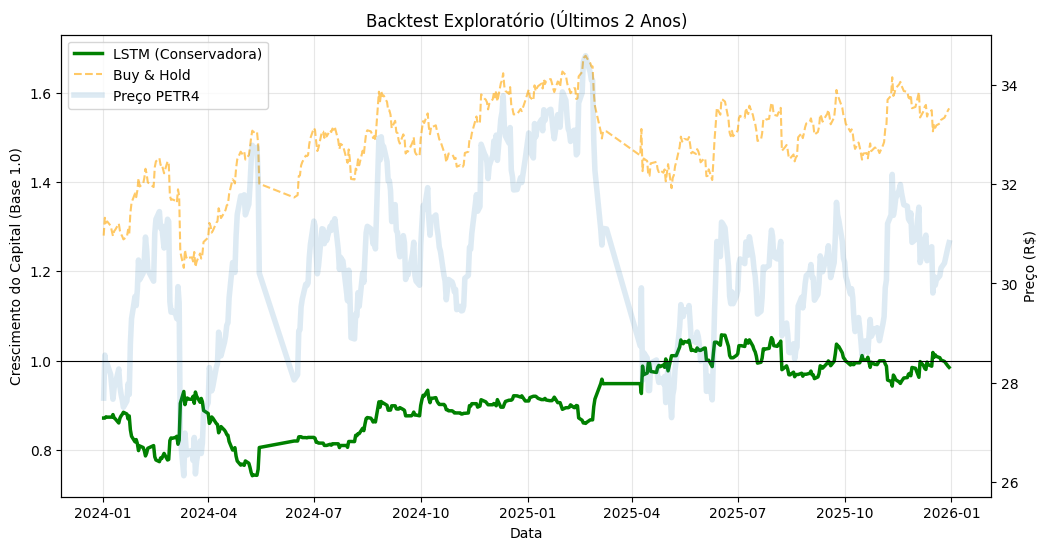

In [41]:
# ==========================================
# 📈 BACKTEST EXPLORATÓRIO (ABORDAGEM CONSERVADORA)
# ==========================================

# 1. Juntar todos os folds
df_trade = pd.concat(all_backtest_data).sort_values('Data').reset_index(drop=True)

# 2. Preço real de fechamento (para visualização)
df_trade['Preco_Real_Fechamento'] = (
    df_trade['Preco_Real_t-1'] * np.exp(df_trade['Real_Log_Return'])
)

# ==========================================
# 3. GERAÇÃO DE SINAL (CONSERVADOR)
# ==========================================

# Limiar mínimo de convicção (ex: 0.15%)
LIMIAR = 0.0015

# Intensidade do sinal: ignora previsões fracas
df_trade['Signal_Strength'] = np.where(
    np.abs(df_trade['Pred_Log_Return']) > LIMIAR,
    df_trade['Pred_Log_Return'],
    0.0
)

# Position sizing contínuo (exposição proporcional ao sinal)
# O divisor controla agressividade; maior = mais conservador
df_trade['Posicao_Conservadora'] = np.clip(
    df_trade['Signal_Strength'] / (3 * LIMIAR),
    -1.0,
    1.0
)

# ==========================================
# 4. CÁLCULO DOS RETORNOS
# ==========================================

# Retorno da estratégia conservadora
df_trade['Retorno_Conservador'] = (
    df_trade['Posicao_Conservadora'] * df_trade['Real_Log_Return']
)

# Buy & Hold (benchmark)
df_trade['Capital_BuyHold'] = np.exp(
    df_trade['Real_Log_Return'].cumsum()
)

# Estratégia LSTM conservadora
df_trade['Capital_LSTM_Conservador'] = np.exp(
    df_trade['Retorno_Conservador'].cumsum()
)

# ==========================================
# 5. RESULTADOS NUMÉRICOS
# ==========================================

ret_bh = (df_trade['Capital_BuyHold'].iloc[-1] - 1) * 100
ret_cons = (df_trade['Capital_LSTM_Conservador'].iloc[-1] - 1) * 100

print('--- RESULTADO FINANCEIRO (BACKTEST EXPLORATÓRIO) ---')
print(f'Retorno Buy & Hold (PETR4): {ret_bh:.2f}%')
print(f'Retorno LSTM (Conservadora): {ret_cons:.2f}%')

# ==========================================
# 6. FILTRO DE VISUALIZAÇÃO (ÚLTIMOS 2 ANOS)
# ==========================================

data_final = df_trade['Data'].max()
data_inicio = data_final - pd.DateOffset(years=2)

df_plot = df_trade[df_trade['Data'] >= data_inicio]

# ==========================================
# 7. GRÁFICO FINAL (EIXO DUPLO)
# ==========================================

fig, ax1 = plt.subplots(figsize=(12, 6))

# Curvas de capital
ax1.plot(
    df_plot['Data'],
    df_plot['Capital_LSTM_Conservador'],
    linewidth=2.5,
    color='green',
    label='LSTM (Conservadora)'
)

ax1.plot(
    df_plot['Data'],
    df_plot['Capital_BuyHold'],
    linestyle='--',
    alpha=0.6,
    color='orange',
    label='Buy & Hold'
)

ax1.axhline(1.0, color='black', linewidth=0.8)
ax1.set_xlabel('Data')
ax1.set_ylabel('Crescimento do Capital (Base 1.0)')
ax1.grid(True, alpha=0.3)

# Preço no eixo secundário
ax2 = ax1.twinx()
ax2.plot(
    df_plot['Data'],
    df_plot['Preco_Real_Fechamento'],
    alpha=0.15,
    linewidth=4,
    label='Preço PETR4'
)
ax2.set_ylabel('Preço (R$)')

# Legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Backtest Exploratório (Últimos 2 Anos)')
plt.show()


## Treinamento Final (Full Dataset)

Agora que validamos que a arquitetura do modelo funciona (pelos testes anteriores), vamos criar a versão definitiva dele.

**Por que fazer isso?**
Nos passos anteriores, sempre reservamos uma parte dos dados para teste (ex: os últimos 6 meses). Isso significa que o modelo gerado lá não conhece os dados mais recentes. Para a API (Deploy), queremos o modelo mais "inteligente" e atualizado possível.

**O Processo:**
1.  Pegar **todos** os dados disponíveis (do início até hoje).
2.  Criar novos **Escaladores (Scalers)** ajustados a todo o histórico.
3.  Retreinar a rede neural do zero com tudo.

In [48]:
print("--- Iniciando Treinamento Final ---")

# 1. Definir o que entra e o que sai
# IMPORTANTE: Remova preços absolutos para o modelo não "viciar" no valor do ativo
# colunas_proibidas = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_200', target_col]

# Garante que só remove o que existe no df
cols_to_drop = [c for c in colunas_proibidas if c in df.columns]

X_full = df.drop(columns=cols_to_drop)
y_full = df[target_col]

print(f"Colunas usadas no X ({len(X_full.columns)}):")
print(list(X_full.columns)) # <--- COPIE ESSA LISTA PARA O SEU predict_petr4.py DEPOIS!

# 2. Novos Escaladores (Scalers)
scaler_X_final = MinMaxScaler()
scaler_y_final = MinMaxScaler()

# O fit_transform devolve um numpy array...
X_full_scaled_array = scaler_X_final.fit_transform(X_full)

# ...Mas sua função create_sequences espera um DataFrame.
# CORREÇÃO: Vamos transformar de volta em DataFrame mantendo as colunas
X_full_scaled = pd.DataFrame(X_full_scaled_array, columns=X_full.columns, index=X_full.index)

# Para o Y, o numpy array geralmente funciona bem, mas vamos garantir
y_full_scaled = scaler_y_final.fit_transform(y_full.values.reshape(-1, 1))

# 3. Criar Sequências (Agora vai funcionar porque X_full_scaled é DataFrame de novo)
X_final_seq, y_final_seq = create_sequences(X_full_scaled, y_full_scaled, LOOKBACK)

print(f"Dados prontos. Formato de entrada: {X_final_seq.shape}")

# 4. Construir o Modelo Final
final_model = build_lstm(input_shape=(X_final_seq.shape[1], X_final_seq.shape[2]))

# 5. Treinamento
early_stop_final = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = final_model.fit(
    X_final_seq,
    y_final_seq,
    validation_split=0.05,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_final],
    verbose=1
)

print("\n--- Treinamento Final Concluído ---")

--- Iniciando Treinamento Final ---
Colunas usadas no X (34):
['USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Dados prontos. Formato de entrada: (2023, 20, 34)
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0266 - val_loss: 8.7201e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 9.3538e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 3.0972e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032 - val_loss: 2.7565e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 3.1

## Exportação do modelo

In [49]:
import joblib

# Salvamento dos Artefatos
# Salvamos o modelo e os scalers. São esses arquivos que você vai mandar para o Deploy.

model_filename = 'lstm_petr4_final.keras'
final_model.save(model_filename)
print(f"✅ Modelo salvo: {model_filename}")

scaler_x_filename = 'scaler_x_final.pkl'
scaler_y_filename = 'scaler_y_final.pkl'

joblib.dump(scaler_X_final, scaler_x_filename)
joblib.dump(scaler_y_final, scaler_y_filename)
print(f"✅ Escaladores salvos: {scaler_x_filename} e {scaler_y_filename}")

print("\nArquivos prontos para serem usados na API!")

✅ Modelo salvo: lstm_petr4_final.keras
✅ Escaladores salvos: scaler_x_final.pkl e scaler_y_final.pkl

Arquivos prontos para serem usados na API!


## Teste Manual (Sanity Check): Simulando o Modelo

Para finalizar, vamos fazer um teste prático para garantir que os arquivos salvos (`.keras` e `.pkl`) estão funcionando perfeitamente.

Nesta célula, vamos simular o comportamento da futura API:
1.  **Carregar** o modelo e os escaladores do disco (como se o servidor tivesse acabado de ligar).
2.  **Pegar os dados mais recentes** do nosso DataFrame (os últimos 20 dias).
3.  **Processar** esses dados aplicando a normalização carregada.
4.  **Realizar uma previsão** para o "dia seguinte".
5.  **Converter** o resultado de volta para Reais (R$).


In [44]:
import joblib

print("--- Iniciando Teste de Sanidade (Simulação de API) ---")

# 1. CARREGAR ARTEFATOS (Como a API faria)
try:
    print("Carregando modelo e scalers do disco...")
    loaded_model = tf.keras.models.load_model('lstm_petr4_final.keras')
    loaded_scaler_X = joblib.load('scaler_x_final.pkl')
    loaded_scaler_y = joblib.load('scaler_y_final.pkl')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar arquivos: {e}")
    raise e

# 2. PREPARAR DADOS DE ENTRADA (Input)
# Vamos pegar exatamente os últimos 'LOOKBACK' dias disponíveis no dataset original
# Isso simula um usuário pedindo a previsão para "amanhã" baseado no fechamento de hoje.
recent_data = df.tail(LOOKBACK).copy()

# Guardamos o preço de fechamento do último dia para calcular a projeção
last_close_price = recent_data['Close'].iloc[-1]
last_date = recent_data.index[-1]

# Removemos a coluna alvo (Log_Return), pois na vida real não saberemos ela para amanhã
input_features = recent_data.drop(columns=[target_col])

# 3. PRÉ-PROCESSAMENTO (Escalonamento)
# Importante: Precisamos separar as colunas cíclicas das numéricas, igual no treino
# 'cyclical_cols' e 'scale_cols' devem estar definidos no notebook anteriormente
input_features_scaled = input_features.copy()

# Aplica o scaler carregado APENAS nas colunas numéricas
input_features_scaled[scale_cols] = loaded_scaler_X.transform(input_features[scale_cols])

# Transforma em array numpy e faz o Reshape para (1, 20, features)
# O '1' indica que estamos prevendo apenas 1 item (batch_size=1)
input_sequence = input_features_scaled.values.reshape(1, LOOKBACK, input_features_scaled.shape[1])

# 4. PREVISÃO (Infference)
print("\nRealizando a previsão com a Rede Neural...")
pred_scaled = loaded_model.predict(input_sequence, verbose=0)

# 5. PÓS-PROCESSAMENTO (Inverter escala e calcular preço)
# O modelo cospe um valor entre 0 e 1 (ou próximo). Precisamos voltar para Log Return.
pred_log_return = loaded_scaler_y.inverse_transform(pred_scaled)[0][0]

# Fórmula: Preço_Amanhã = Preço_Hoje * exp(Log_Return_Previsto)
predicted_price = last_close_price * np.exp(pred_log_return)

# Define a cor/direção para o print
direction = "ALTA 🟢" if pred_log_return > 0 else "BAIXA 🔴"

print("\n" + "="*40)
print(f"RESULTADO DA PREVISÃO (Baseado em {last_date.date()})")
print("="*40)
print(f"Último Preço Real (Fechamento): R$ {last_close_price:.2f}")
print(f"Retorno Logarítmico Previsto  : {pred_log_return:.6f}")
print(f"Tendência Prevista            : {direction}")
print(f"Preço Projetado para Amanhã   : R$ {predicted_price:.2f}")
print("="*40)

--- Iniciando Teste de Sanidade (Simulação de API) ---
Carregando modelo e scalers do disco...
✅ Arquivos carregados com sucesso!

Realizando a previsão com a Rede Neural...

RESULTADO DA PREVISÃO (Baseado em 2025-12-30)
Último Preço Real (Fechamento): R$ 30.82
Retorno Logarítmico Previsto  : 0.000297
Tendência Prevista            : ALTA 🟢
Preço Projetado para Amanhã   : R$ 30.83
